In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load in all depth vs resistance curves into a df list

In [48]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
    return depth_resist_curve_df_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list = load_data(data_src)

In [49]:
data_features_df = pd.read_csv("data/features.csv")
clustering_features_df = data_features_df.drop(['filenames', 'y_labels'], axis=1)

# Visualization Functions

In [50]:

# unique coloring mappings for categories
label_color_map = {0: 'red', 1: 'gold', 2: 'blue', 3: 'green', 4: 'purple', 5: 'pink',
        6: 'brown', 7: 'orange', 8: 'cyan', 9: 'magenta', 10: 'yellow',
        11: 'lime', 12: 'teal', 13: 'navy', 14: 'maroon', 15: 'olive',
        16: 'coral', 17: 'grey', 18: 'salmon', 19: 'turquoise'}

# size of figures produced
size_fig = (4,3)

# given a cluster color, this returns the filenames associated
def get_curve_idx_from_cluster_color(color, y_labels, data_features_df):
    print(f"Indexes of curves assigned to {color} cluster: ")
    for i, label in enumerate(y_labels):
        if label_color_map[label] == color:
            print(data_features_df['filenames'].iloc[i])

def visualize_clusters(representation_list, y_labels, graph_title="", generate_plot_idx=[-1], kmeans_centroids=False, use_pca=False, two_d=False, 
                       plot_all_curves_oneplot=False, cluster_i_overlay=False, cluster_i_plot_labels=[]):
    if generate_plot_idx[0] != -1:
        combined_columns = pd.concat(depth_resist_curve_df_list)
        for idx in generate_plot_idx:
            plt.figure(figsize=size_fig)
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            plt.title('Depth vs Resistance Curve')
            plt.xlim([0, combined_columns["depth"].max()])
            plt.ylim([0, combined_columns["resistance"].max()])
            plt.plot(depth_resist_curve_df_list[idx]["depth"], depth_resist_curve_df_list[idx]["resistance"], c='black')
    
    if use_pca:
        # calculate PCA
        pca = PCA(n_components=2) # reduce data down to 2 dims
        # print(f"representation_list: {representation_list.values}")
        pca.fit(representation_list.values)
        X_pca = pca.transform(representation_list.values)
        # plot
        plt.figure(figsize=size_fig)
        plt.title(f"{graph_title} Clustering Visualized with pca")
        colors = [label_color_map[label] for label in y_labels]
        plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, alpha=0)
        for i in range(X_pca.shape[0]): # loops over every point
            plt.text(X_pca[i,0], X_pca[i,1], str(i), c=label_color_map[y_labels[i]], fontsize=8)

        # special cases per algorithm used
        if graph_title.lower() == "kmeans" and kmeans_centroids.any():
            centroids_pca = pca.transform(kmeans_centroids)
            plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="Red", marker="^", s=180)
        if graph_title.lower() == "dbscan":
            plt.scatter([], [], c=label_color_map[max(y_labels)], label='Outliers')
            plt.legend()

        # plot
        plt.savefig(f"figures/{graph_title.lower()}/PCA", bbox_inches='tight')
        plt.show()
        plt.close() # clear figure 

    if plot_all_curves_oneplot:
        a = 0.3
        combined_columns = pd.concat(depth_resist_curve_df_list, axis=0, ignore_index=True)
        plt.figure(figsize=size_fig)
        for i, y in enumerate(y_labels):
            df = depth_resist_curve_df_list[i]
            color = label_color_map.get(y, 'black')  # default to black if label not in map
            plt.plot(df["depth"], df["resistance"], color=color, alpha=a)
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title('Depth vs Resistance Curves')
        plt.xlim([0, combined_columns["depth"].max()])
        plt.ylim([0, combined_columns["resistance"].max()])
        plt.savefig(f"figures/{graph_title.lower()}/cluster_curves", bbox_inches='tight')
        plt.show()
        plt.close() # clear figure 

    if cluster_i_overlay:
        combined_columns = pd.concat(depth_resist_curve_df_list, axis=0, ignore_index=True)
        a = 1
        # color_list = ["Red", "Grey", "Blue", "Green", "Purple", "Pink", "Brown"]
        for i in range(max(y_labels)+1): # for each cluster, +1 bc clusters are 0 indexed too
            plt.figure(figsize=size_fig)
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            plt.xlim([0, combined_columns["depth"].max()])
            plt.ylim([0, combined_columns["resistance"].max()])

            if len(cluster_i_plot_labels): plt.title(f'{cluster_i_plot_labels[i].title()} Cluster: Depth vs Resistance Curves')
            else: plt.title(f'{label_color_map.get(i, 'black').capitalize()} Cluster: Depth vs Resistance Curves')
            
            for j in range(len(y_labels)): # for each curve in cluster i
                if i == y_labels[j]: # if the curve is in cluster
                    color = label_color_map.get(i, 'black')
                    plt.plot(depth_resist_curve_df_list[j]["depth"], depth_resist_curve_df_list[j]["resistance"], color=color, alpha=a)
            plt.savefig(f"figures/{graph_title.lower()}/{color}_cluster", bbox_inches='tight')
            plt.show()
            plt.close() # clear figure 

    if two_d and len(representation_list.columns) == 2:
        x = representation_list.columns[0]
        y = representation_list.columns[1]
        plt.scatter(representation_list[x], representation_list[y], c=y_labels, cmap="coolwarm")
        plt.title(f"{graph_title} Clustering: {x} and {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()
        plt.close() # clear figure 

# Spatial Analysis of Clustering
plan:
- different plots for different transects and/or locations (t1,t2,t3)

# PCA Analysis

In [51]:

def pca_analysis(representation_list):
    pca = PCA(n_components=len(representation_list.columns))
    pca.fit(representation_list.values)

    # plot scree plot
    plt.figure(figsize=size_fig)
    plt.title("Scree Plot")
    plt.xlabel("PC Number")
    plt.ylabel("Eigenvalue")
    plt.xticks(range(1, pca.n_components_+1))
    plt.plot(range(1, pca.n_components_+1), pca.explained_variance_)
    plt.show()

    # principal component table
    principle_components_table = pd.DataFrame({
        "PC": range(1,pca.n_components_+1),
        "Eigenvalue": pca.explained_variance_,
        "Proportion": pca.explained_variance_ratio_
    })
    principle_components_table.set_index('PC', inplace=True)
    principle_components_table["Cumulative"] = principle_components_table["Proportion"].cumsum()
    print(principle_components_table)

    loadings = pca.components_.T
    pc_labels = [f'PC{i+1}' for i in range(loadings.shape[1])]
    loadings_df = pd.DataFrame(loadings, index=representation_list.columns, columns=pc_labels)
    print('\n')
    print(loadings_df)

# Clustering Only Labled Data Points

In [52]:
labled_data_features_df = data_features_df[data_features_df['y_labels'].notna()].reset_index(drop=True) # removes NaN's which correspond to non-labled data
# encodes object into categorical variables
labled_data_features_df['encoded'], uniques = pd.factorize(labled_data_features_df['y_labels'])
# visualize_clusters(labled_data_features_df.drop(['filenames', 'y_labels', 'encoded'], axis=1), y_labels=labled_data_features_df['encoded'].tolist(), graph_title="Ground_Truth", 
#                    use_pca=True, plot_all_curves_oneplot=True, cluster_i_overlay=True, cluster_i_plot_labels=uniques)

# K-Means Clustering Implementation w/ k-means++ initialization for centroids

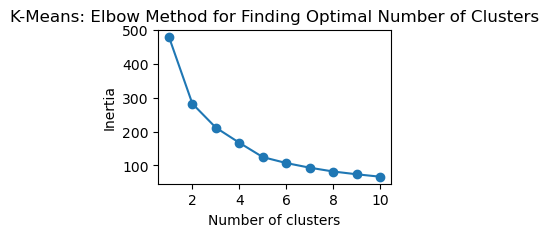

In [53]:
from sklearn.cluster import KMeans
import numpy as np

inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(clustering_features_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,11), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

In [54]:
kmeans_elbow = 6
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(clustering_features_df)
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")
# pca_analysis(clustering_features_df) # printing scree plot
# visualize_clusters(clustering_features_df, kmeans.labels_, graph_title="KMeans", kmeans_centroids=kmeans.cluster_centers_, use_pca=True, two_d=False, plot_all_curves_oneplot=True, cluster_i_overlay=True)

# Hierarchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=11)
hierarchical.fit(clustering_features_df)
linkage = "Ward"
# get_curve_idx_from_cluster_color("green", hierarchical.labels_, data_features_df)
# visualize_clusters(clustering_features_df, hierarchical.labels_, graph_title="Hierarchical", use_pca=True, plot_all_curves_oneplot=True, cluster_i_overlay=True)

Indexes of curves assigned to green cluster: 
WS23_L2_T1_P_6.csv
WS23_L3_T1_P_29.csv
WS23_L3_T1_P_2.csv
WS23_L3_T1_P_24.csv
WS23_L1_T1_P_19.csv
WS23_L2_T1_P_17.csv
WS23_L1_T1_P_2.csv


# Manual Clustering

In [56]:
from collections import defaultdict

label_color_map = {0: 'red', 1: 'gold', 2: 'blue', 3: 'green', 4: 'purple', 5: 'pink',
        6: 'brown', 7: 'orange', 8: 'cyan', 9: 'magenta', 10: 'maroon',
        11: 'lime', 12: 'teal', 13: 'navy', 14: 'yellow', 15: 'olive',
        16: 'coral', 17: 'grey', 18: 'salmon', 19: 'turquoise', 20: 'black'}

y_labels = [0,9,1,2,1,0,3,4,0,5,
            5,2,0,2,1,6,7,0,4,8,
            9,0,10,0,2,7,9,10,0,
            8,8,9,0,0,10,8,0,4,1,
            10,3,8,0,0,10,0,1,8,2,
            6,9,6,0,8,2,11,0,8,5,
            8,0,2,3,9,8,1,8,0,8,
            5,8,7,2,0,11,2,6,5,8,
            6]

color_indices = [i for i, val in enumerate(y_labels) if val == 6]

# visualize_clusters(clustering_features_df, [20], generate_plot_idx=color_indices)
# visualize_clusters(clustering_features_df.iloc[:len(y_labels)], y_labels, generate_plot_idx=[len(y_labels)-1], cluster_i_overlay=True)

# DBSCAN

In [57]:
from sklearn.cluster import DBSCAN

# eps=0.7, min_samples=3 works very well
dbscan = DBSCAN(eps=0.7, min_samples=5).fit(clustering_features_df)
cleaned_db_labels = [label if label != -1 else max(dbscan.labels_)+1 for label in dbscan.labels_]
# get_curve_idx_from_cluster_color("yellow", cleaned_db_labels)
# visualize_clusters(clustering_features_df, y_labels = cleaned_db_labels, graph_title="DBSCAN", use_pca=True, plot_all_curves_oneplot=True, cluster_i_overlay=True)